In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import quandl as ql
import seaborn as sns
import scipy.stats
import pandas_datareader as pdr
from datetime import datetime
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

#### European Payoff of call-option

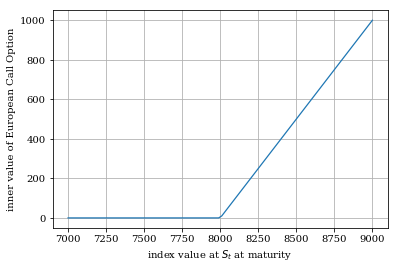

In [16]:
#Option Strike
K = 8000
S = np.linspace(7000,9000, 100) #strikes
#vectorized computing of payoff values 
h = np.maximum(S-K, 0)

plt.figure()
plt.plot(S,h, lw=1.25);
plt.xlabel('index value at $S_t$ at maturity');
plt.ylabel('inner value of European Call Option');
plt.grid(True)

This looks like the [__RELU function__](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) that Taleb was mentioning 

#### The moneyness of an option
* In the money (ITM): call (put) is ITM if S > K (K>S)
* At the money (ATM: call or put is ATM if S~K 
* Out of the money (OTM): call (put) is OTM if K > S (S>K)

#### What influences the value of an option?
* Initial Index Level
* Volatlity: gamma
* Time to maturity: Delta
* Interest Rate: For European options, you must discount their value according to interest rate


#### Black-Scholes-Merton formula attempts to value options according to these factors

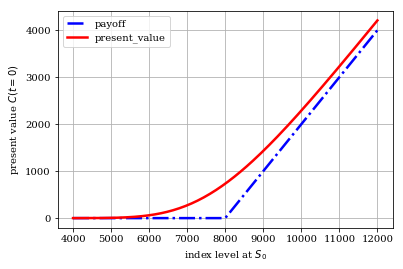

In [25]:
from BSM_option_valuation import BSM_call_value



K = 8000
T = 1.0 # time to maturity
r = 0.025 # constant risk-free rate
vol = 0.2 #Volatility

S = np.linspace(4000, 12000, 150)
h = np.maximum(S - K, 0)
C = [BSM_call_value(S0, K, 0, T, r, vol) for S0 in S]

plt.figure()
plt.plot(S, h, 'b-.', lw=2.5, label='payoff');
plt.plot(S, C, 'r', lw=2.5, label='present_value')
plt.grid(True)
plt.legend(loc=0)
plt.xlabel('index level at $S_0$')
plt.ylabel('present value $C(t=0)$');

Financial markets distinguish between plain vanilla or flow equity derivatives, 
like European call options written on an equity index, and exotic equity derivatives, 
like options on an equity index with Asian features, barriers and/or American exercise.
In general, there exist liquid markets for plain vanilla products but not for exotic ones. 
In contrast, exotic derivatives are often tailored by financial institutions to specific 
client needs and are not traded at all (or “only once” if you like).

Nevertheless, financial institutions writing exotic equity options (so-called sell side) 
or clients buying these options (i.e. the buy side) must have a mechanism to derive 
fair values regularly and transparently. In addition, option writers must be able to 
hedge their exposure. In relation to exotic equity derivatives, sellers and buyers 
must often resort to numerical methods, like Monte Carlo simulation, to come up 
with fair values and appropriate hedging strategies.



Hilpisch, Yves. Derivatives Analytics with Python: Data Analysis, Models, Simulation, Calibration and Hedging (The Wiley Finance Series) (p. 13). Wiley. Kindle Edition. 

#### Risks affecting the valuation of options

* price risk
* volatility risk
* jump or crash risk
* interest-rate risk
* correlation risk
* liquidity risk: it seems this is hard to model. The liquidity changes according to volality and jump-risk. 
* default-risk

* Frequency of hedging rebalancing and market incompleteness force more risk-minimization than elimination

#### Stylized-facts from empirical evidence that contradict the BSM models
* stochastic volatility: there is no mechanism to forecast volatility at high-confidence
* volatility clustering: positive autocorrelation of volatility, i.e volatility leads to volatility
* volatility is mean-reverting: never goes to zero or infinity. The mean can change through time
* leverage affect: negatively correlated with asset returns 
* fat-tails: compared to normal distribution large positive and negative returns are more frequent
* index levels move by levels not explained by gaussian processes

In [48]:
start = datetime(2014, 10, 1)
end = datetime(2019, 2, 24)
# dax_etf = pdr.DataReader('.GDAXI', 'iex', start, end)

In [98]:
def get_da(symbol, start, end):

    DAX = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data_long.csv',
                          index_col=0, parse_dates=True)[symbol]

    DAX = pd.DataFrame(DAX)
    DAX = DAX.loc[start:end]
    DAX.rename(columns={'.GDAXI': 'index'}, inplace=True)
    DAX['returns'] = np.log(DAX['index'] / DAX['index'].shift(1))
    DAX['rea_var'] = 252 * np.cumsum(DAX['returns'] ** 2) / np.arange(len(DAX))
    DAX['rea_vol'] = np.sqrt(DAX['rea_var'])
    DAX = DAX.dropna()
    return DAX

def return_qqplot(data,dist):
    import statsmodels.api as sm
    ''' Generates a Q-Q plot of the returns.'''
    plt.figure(figsize=(9, 5))
    sm.qqplot(data['returns'], dist=dist, line='s')
    plt.grid(True)
    plt.xlabel('theoretical quantiles')
    plt.ylabel('sample quantiles')

#### Visual Inspection of the index values and daily returns
* Volatility clearly shifts through time 
* We can see mean-reverting behavior
* We can also see volatility clustering


#### Our question is: Do we have evidence of normality or fat-tails?

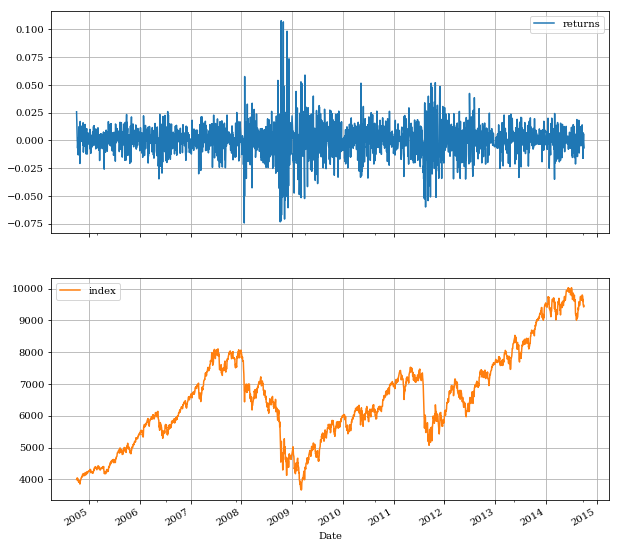

In [96]:
DAX[['returns', 'index']].plot(subplots=True, layout=(2,1), figsize=(10,10), grid=True);

* Returns are not normally distributed
* We have more kurtosis 
* There are more observations in the tails

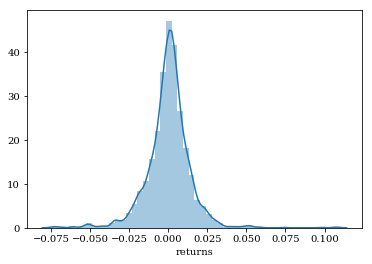

In [97]:
sns.distplot(DAX['returns'], bins=50);

* The QQ-plot of our returns vs. theoretical normal distribution shows non-normal behavior

<Figure size 648x360 with 0 Axes>

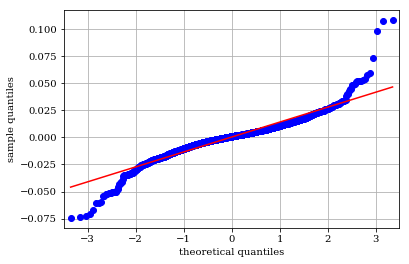

In [99]:
# DAX['returns']
return_qqplot(DAX, dist=scipy.stats.distributions.norm);

In [106]:
import GBM
GBM.print_statistics(DAX)

RETURN SAMPLE STATISTICS
---------------------------------------------
Mean of Daily  Log Returns  0.000254
Mean of Annua. Log Returns  0.063987
Std  of Annua. Log Returns  0.218582
---------------------------------------------
Skew of Sample Log Returns  0.036871
Skew Normal Test p-value    0.449487
---------------------------------------------
Kurt of Sample Log Returns  7.300400
Kurt Normal Test p-value    0.000000
---------------------------------------------
Normal Test p-value         0.000000
---------------------------------------------
Realized Volatility         0.214515
Realized Variance           0.046017


* Volatility varies over time and does not converge

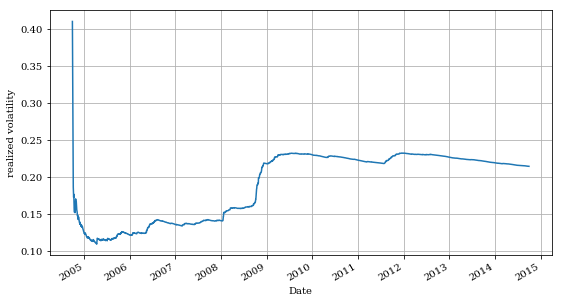

In [107]:
GBM.realized_volatility(DAX)

* Rolling volatility is mean reverting but shifts between 10% to 40%
* Volatility is often almost completely negatively correlated with returns

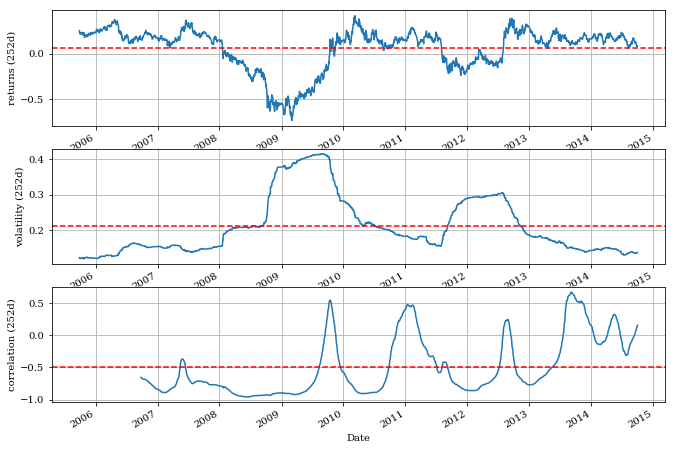

In [115]:
GBM.rolling_statistics(DAX)

* How many days are there with returns greater than 5%?  
* We have almost 2800 obs. If normally distributed we'd expect to see less than one observation in the tail
* We have 32 obs in the tails so these are fat-tailed distributions

In [109]:
def count_jumps(data, value):
    ''' Counts the number of return jumps as defined in size by value. '''
    jumps = np.sum(np.abs(data['returns']) > value)
    return jumps

In [112]:
count_jumps(DAX, 0.05)

32

* Our data does not behave like the model based on Brownian Geometric motion
* Autocorrelated stochastic volatility (volatility clustering)
* Volatility mean-reversion
* leverage effect (negative correlation between returns and volatility)
* Fat-tails and jumps 